# 1. Import Dependencies and Datasets

In [ ]:
# !pip install tensorflow tensorflow-gpu tensorflow-datasets matplotlib ipywidgets

In [ ]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist', split="train")

In [ ]:
ds.as_numpy_iterator().next()["label"]

2

# **2. Viz Data and Build Datasets**


In [ ]:
import numpy as np

In [ ]:
#setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [ ]:
# getting data out of pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

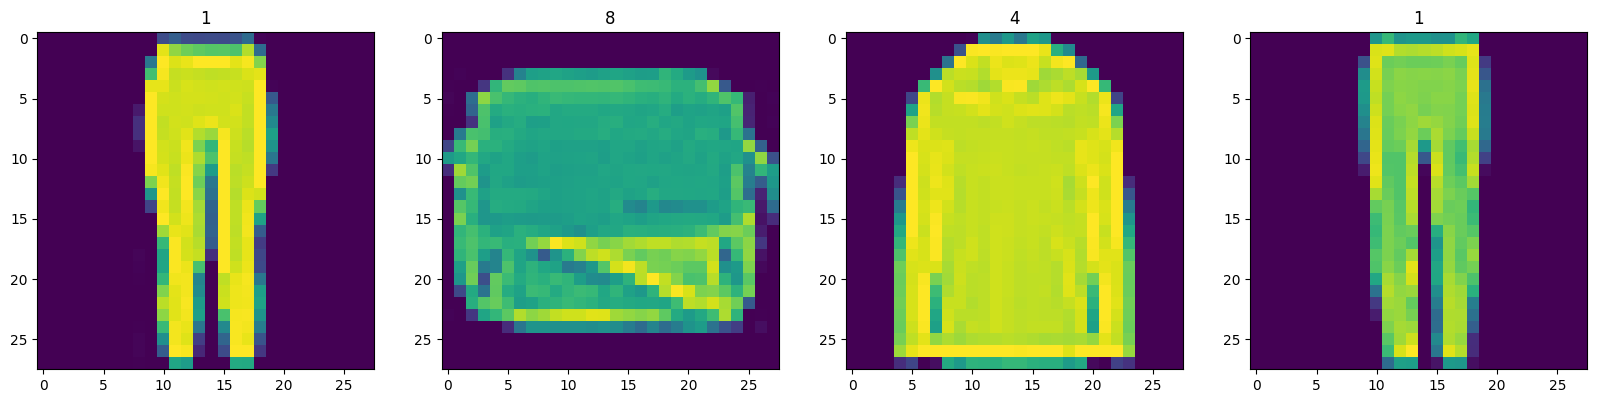

In [ ]:
#setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
  #grab an image and label
  sample = dataiterator.next()
  #plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # appending the image label at the plot title
  ax[idx].title.set_text(sample['label'])

In [ ]:
# Scale and return images only
def scale_images(data):
  image = data['image']
  return image/255

In [ ]:
#Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
#Runnig the dataset through scale_images prepocessing step
ds = ds.map(scale_images)
#cache the datasets for the batch
ds = ds.cache()
#Shuffle it up
ds = ds.shuffle(60000)
#Batch in to 128 images per sample
ds = ds.batch(128)
#Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network



#3.1. Import Modelling Components


In [ ]:
#Bring in the sequential api for the generator and descriminator
from tensorflow.keras.models import Sequential
#Bring in the layers for neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D


#3.2. Build the Generator


In [ ]:
def build_generator():

  #Takes in random values and reshape it to 7x7x128
  #Beginning of a generated image
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5,padding = "same"))
  model.add(LeakyReLU(0.2))

  #Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5,padding = "same"))
  model.add(LeakyReLU(0.2))

  #Downsampling block 1
  model.add(Conv2D(128, 4,padding = "same"))
  model.add(LeakyReLU(0.2))

   #Downsampling block 2
  model.add(Conv2D(128, 4,padding = "same"))
  model.add(LeakyReLU(0.2))

  #ConV Layer to get to one channel
  model.add(Conv2D(1, 4, padding = "same", activation="sigmoid"))

  return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 149ms/step


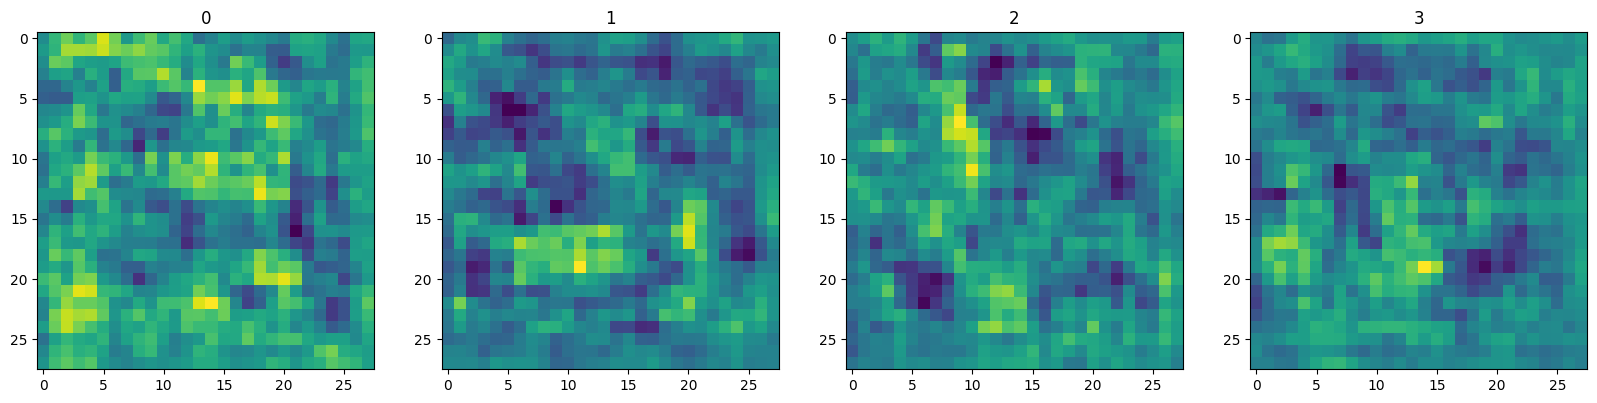

In [ ]:
#Generation new fashion
img = generator.predict(np.random.randn(4,128,1))
#setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(img):
  #plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # appending the image label at the plot title
  ax[idx].title.set_text(idx)

#3.3  Build Discriminator

In [ ]:
def build_discriminator():
  model = Sequential()

  #first conv block
  model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second conv block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Third conv block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Four conv block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))

  return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 128)      

In [ ]:
# discriminator.predict(img)

#4. Construct Tranning Loop

# 4.1 Setup Losses and Optimizers

In [ ]:
#Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy if going to be the loss for the both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate =0.0001)
d_opt = Adam(learning_rate =0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# 4.2 Build SubClasses Model

In [ ]:
#Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
tf.concat([tf.zeros_like(tf.random.normal((6, 128, ))), tf.ones_like(tf.random.normal((6, 128)))], axis=0)

<tf.Tensor: shape=(12, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    #Pass through args and kwargs to base class
    super().__init__(*args, **kwargs)
    # Create attributes for gen and dis
    self.generator = generator
    self.discriminator = discriminator

  def compile (self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    #Compile with base class
    super().compile(*args, **kwargs)
    # Create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step (self, batch):
    # Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

    #Train the discriminator
    with tf.GradientTape() as d_tape:
    #Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

    #Create labels for the real and fake images
    y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

    #Add some noise to the outputs
    noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
    noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
    y_realfake += tf.concat([noise_real, noise_fake], axis=0)

    #Calculate loss
    total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    #Apply backpropagation - nn Learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #Train the generator
    with tf.GradientTape() as g_tape:
      #Generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training = True)

      #Create the predicted Labels
      predicted_labels = self.discriminator(gen_images, training=False)

      #Calculate loss - trick to traning to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

      #Apply backprop
      ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
      self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

      return {"d_loss": total_d_loss, "g_loss": total_g_loss}


In [ ]:
#Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

# 4.3 Build callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_letent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_letent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images',f'generated_img_{epoch}_{i}.png'))

# 4.4 Train

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "<ipython-input-134-c7a5f8622b25>", line 43, in train_step
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1222, in apply_gradients
        grads_and_vars = self.aggregate_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1184, in aggregate_gradients
        return optimizer_utils.all_reduce_sum_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/utils.py", line 33, in all_reduce_sum_gradients
        filtered_grads_and_vars = filter_empty_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['conv2d_18/kernel:0', 'conv2d_18/bias:0', 'conv2d_19/kernel:0', 'conv2d_19/bias:0', 'conv2d_20/kernel:0', 'conv2d_20/bias:0', 'conv2d_21/kernel:0', 'conv2d_21/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'conv2d_18/kernel:0' shape=(5, 5, 1, 32) dtype=float32>), (None, <tf.Variable 'conv2d_18/bias:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'conv2d_19/kernel:0' shape=(5, 5, 32, 64) dtype=float32>), (None, <tf.Variable 'conv2d_19/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_20/kernel:0' shape=(5, 5, 64, 128) dtype=float32>), (None, <tf.Variable 'conv2d_20/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_21/kernel:0' shape=(5, 5, 128, 256) dtype=float32>), (None, <tf.Variable 'conv2d_21/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'dense_4/kernel:0' shape=(36864, 1) dtype=float32>), (None, <tf.Variable 'dense_4/bias:0' shape=(1,) dtype=float32>)).


# 4.5 Review Performance

In [ ]:
plt.subtitle("Loss")
plt.plot(his.history['d_loss'], label='d_loss')
plt.plot(his.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test out the generator

# 5.1 Generate Images

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols = 4, nrows=4, figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

# 5.2 Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [ ]:
!git config --global user.email "phungdat020501@gmail.com"
!git config --global user.name "Tất Đạt"

In [ ]:
!git init
!git add FashionGAN.ipynb
!git commit -m "first commit"
!git remote add origin git@github.com:Datpt0205/FashionGAN.git
!git push -u origin master

Reinitialized existing Git repository in /content/.git/
fatal: pathspec 'FashionGAN.ipynb' did not match any files
On branch main

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)
error: remote origin already exists.
error: src refspec master does not match any
error: failed to push some refs to 'github.com:Datpt0205/FashionGAN.git'
